In [1]:
from PyAWD.AcousticWaveDataset import *
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
import torch

sns.set_theme()

In [2]:
train = torch.load("../../../local/datasets/AWD/train.pt")
X = [torch.Tensor(np.array([train.interrogate(i, inter) for inter in train.interrogators]).flatten()) for i in range(train.size)]
Y = [torch.Tensor([train[i][0][0]/(train.nx/2)]) for i in range(train.size)]

In [3]:
print(X[0].shape)

torch.Size([4000])


In [4]:
test = torch.load("../../../local/datasets/AWD/test.pt")
X_test = [torch.Tensor(np.array([test.interrogate(i, inter) for inter in test.interrogators]).flatten()) for i in range(test.size)]
Y_test = [torch.Tensor([test[i][0][0]/(test.nx/2)]) for i in range(test.size)]

In [5]:
def train_loop(X, Y, model, loss_fn, optimizer):
    model.train()
    for i in range(len(X)):
        pred = model(X[i])
        loss = loss_fn(pred, Y[i])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_loop(X, Y, model):
    model.eval()
    loss = 0
    for i in range(len(X)):
        pred = model(X[i])
        loss += loss_fn(pred, Y[i]).item()
    return loss/len(X)      

In [6]:
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()

        self.linear1 = torch.nn.Linear(X[0].shape[0], X[0].shape[0]//2)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(X[0].shape[0]//2, 1)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.tanh(x)
        return x

model = FFN()
learning_rate = 5*1e-3
epochs = 60
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

In [7]:
for e in tqdm(range(epochs)):
    train_loop(X, Y, model, loss_fn, optimizer)
    losses.append(test_loop(X_test, Y_test, model))

  0%|          | 0/60 [00:00<?, ?it/s]

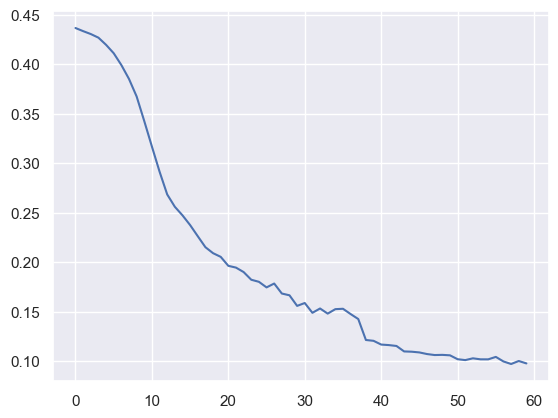

In [8]:
plt.plot(losses)

MAE: 0.09771688694308978


Text(0.5, 1.0, 'Feed-Forward Neural Network')

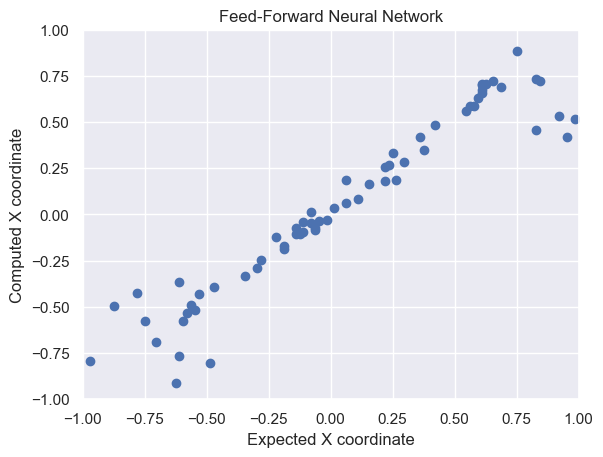

In [21]:
y_test= np.array([i.item() for i in Y_test])
y_hat = np.array([model.forward(i).detach().item() for i in X_test])
nn_mae = np.mean(np.abs(y_test-y_hat))
print("MAE:", nn_mae)
plt.scatter(y, y_hat)
plt.xlabel("Expected X coordinate")
plt.ylabel("Computed X coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Feed-Forward Neural Network")